# Load the Images

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

# gpu setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# start a new wandb run
wandb.init(project='bird classification', entity='heefjones', 
           config = {
                "learning_rate": 0.001,
                "epochs": 10,
                "batch_size": 32
})

(224, 224, 3)


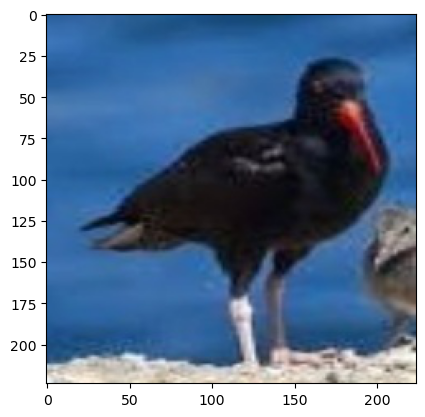

In [11]:
# look at an image
image_path = 'data/train/AFRICAN OYSTER CATCHER/081.jpg'
image = plt.imread(image_path)
print(image.shape)
plt.imshow(image);

In [6]:
# image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor()
])

In [7]:
# create datasets
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)
valid_dataset = datasets.ImageFolder(root='data/valid', transform=transform)

In [8]:
# total train images, shape of a single image
print(len(train_dataset))
print(train_dataset[0][0].shape)

84635
torch.Size([3, 224, 224])


In [9]:
# create dataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)

# Simple CNN

In [14]:
# create a CNN class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # convolutional
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # batch norm
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        
        # max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # dropout
        self.dropout = nn.Dropout(0.5)
        
        # dense layer -> takes in flattened input
        self.fc1 = nn.Linear(64 * 28 * 28, 1024)

        # output layer
        self.fc2 = nn.Linear(1024, 525)
        
    def forward(self, x):
        # convolution -> batch norm -> relu -> max pool
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        
        # flatten the output for dense layer
        x = x.view(-1, 64 * 28 * 28)
        
        # dense layer with relu and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
        
        return x

### Shapes

Input:
- [32, 3, 224, 224]

After conv1/pool:
- [32, 32, 112, 112]

After conv2/pool:
- [32, 64, 56, 56]

After conv3/pool:
- [32, 128, 28, 28]

After flatten:
- [32, 100352]

After fc1:
- [32, 512]

After dropout:
- [32, 512]

After fc2:
- [32, 525]

In [15]:
# create a model
model = CNN().to(device)

In [16]:
# define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [17]:
n_epochs = wandb.config.epochs

# train the model
for epoch in range(n_epochs):
    # training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.item() * images.size(0))
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # train metrics
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100.0 * correct_train / total_train
    
    # validation
    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.inference_mode():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            valid_loss += (loss.item() * images.size(0))
            _, predicted = torch.max(output, 1)
            correct_valid += (predicted == labels).sum().item()
            total_valid += labels.size(0)
    
    # val metrics
    valid_loss = valid_loss / len(valid_loader.dataset)
    valid_accuracy = 100.0 * correct_valid / total_valid
    
    # log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "valid_loss": valid_loss,
        "valid_accuracy": valid_accuracy
    })
    
    # print metrics
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

# finish run
wandb.finish()


Epoch 1/10, Train Loss: 6.3632, Train Acc: 0.26%, Valid Loss: 6.2653, Valid Acc: 0.19%
Epoch 2/10, Train Loss: 6.2586, Train Acc: 0.31%, Valid Loss: 6.2674, Valid Acc: 0.19%
Epoch 3/10, Train Loss: 6.2588, Train Acc: 0.31%, Valid Loss: 6.2689, Valid Acc: 0.19%
Epoch 4/10, Train Loss: 6.2575, Train Acc: 0.31%, Valid Loss: 6.2697, Valid Acc: 0.19%
Epoch 5/10, Train Loss: 6.2573, Train Acc: 0.31%, Valid Loss: 6.2701, Valid Acc: 0.19%
Epoch 6/10, Train Loss: 6.2573, Train Acc: 0.31%, Valid Loss: 6.2704, Valid Acc: 0.19%
Epoch 7/10, Train Loss: 6.2573, Train Acc: 0.31%, Valid Loss: 6.2705, Valid Acc: 0.19%
Epoch 8/10, Train Loss: 6.2573, Train Acc: 0.31%, Valid Loss: 6.2705, Valid Acc: 0.19%
Epoch 9/10, Train Loss: 6.2573, Train Acc: 0.31%, Valid Loss: 6.2705, Valid Acc: 0.19%
Epoch 10/10, Train Loss: 6.2573, Train Acc: 0.31%, Valid Loss: 6.2705, Valid Acc: 0.19%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇████████
train_loss,█▁▁▁▁▁▁▁▁▁
valid_accuracy,▁▁▁▁▁▁▁▁▁▁
valid_loss,▁▄▆▇▇█████
epoch,10
train_accuracy,0.31075
train_loss,6.25733
valid_accuracy,0.19048
valid_loss,6.27054


In [18]:
# save the model
# torch.save(model.state_dict(), 'models/model_2.pth')

# Goals
- Merge models to wandb.ai dashboard
- Streamlit model deployment where user can upload a bird image and get a prediction